In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error
import pickle

In [2]:
import mlflow

mlflow.set_tracking_uri('sqlite:///mflow.db') 


mlflow.set_experiment('nyc-taxi-experiment')

2024/05/23 14:26:31 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2024/05/23 14:26:31 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Running upgrade acf3f17fdcc7 -> 867495a8f9d4, add trace tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.


<Experiment: artifact_location='/home/t.sukanmi/mlops_pratical/experiment_tracking/mlruns/1', creation_time=1716298414868, experiment_id='1', last_update_time=1716298414868, lifecycle_stage='active', name='nyc-taxi-experiment', tags={}>

### Data preprocessing Feature Engineering

In [3]:
# read dataframe function that read data and performs data preprocessing 
def read_dataframe(filename):
    df = pd.read_parquet(filename)
    
    df.tpep_dropoff_datetime = pd.to_datetime(df.tpep_dropoff_datetime)
    df.tpep_pickup_datetime = pd.to_datetime(df.tpep_pickup_datetime)

    df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    
    return df
    
 

In [4]:
# Feeding the data to the function
df_train = read_dataframe('./data/yellow_tripdata_2023-01.parquet')
df_val = read_dataframe('./data/yellow_tripdata_2023-02.parquet')

### Vectorization of training data
#### Splitting data to train and test, training the dictionary vectorizer, and tuning the data frame into a feature matrix

In [5]:
df_train

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,duration
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,9.30,1.00,0.5,0.00,0.0,1.0,14.30,2.5,0.00,8.433333
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,7.90,1.00,0.5,4.00,0.0,1.0,16.90,2.5,0.00,6.316667
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,N,48,238,1,14.90,1.00,0.5,15.00,0.0,1.0,34.90,2.5,0.00,12.750000
3,1,2023-01-01 00:03:48,2023-01-01 00:13:25,0.0,1.90,1.0,N,138,7,1,12.10,7.25,0.5,0.00,0.0,1.0,20.85,0.0,1.25,9.616667
4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,N,107,79,1,11.40,1.00,0.5,3.28,0.0,1.0,19.68,2.5,0.00,10.833333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3066761,2,2023-01-31 23:58:34,2023-02-01 00:12:33,NaN,3.05,NaN,None,107,48,0,15.80,0.00,0.5,3.96,0.0,1.0,23.76,NaN,NaN,13.983333
3066762,2,2023-01-31 23:31:09,2023-01-31 23:50:36,NaN,5.80,NaN,None,112,75,0,22.43,0.00,0.5,2.64,0.0,1.0,29.07,NaN,NaN,19.450000
3066763,2,2023-01-31 23:01:05,2023-01-31 23:25:36,NaN,4.67,NaN,None,114,239,0,17.61,0.00,0.5,5.32,0.0,1.0,26.93,NaN,NaN,24.516667
3066764,2,2023-01-31 23:40:00,2023-01-31 23:53:00,NaN,3.15,NaN,None,230,79,0,18.15,0.00,0.5,4.43,0.0,1.0,26.58,NaN,NaN,13.000000


In [6]:
df_train['duration'].describe()

count    3.009173e+06
mean     1.420486e+01
std      9.939386e+00
min      1.000000e+00
25%      7.216667e+00
50%      1.155000e+01
75%      1.818333e+01
max      6.000000e+01
Name: duration, dtype: float64

In [7]:
std_dev_january = df_train['duration'].std()
std_dev_january

9.939385620151036

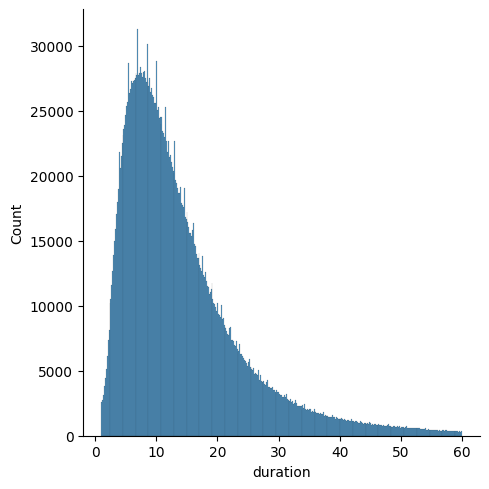

In [8]:
sns.displot(df_train['duration'])

plt.show()

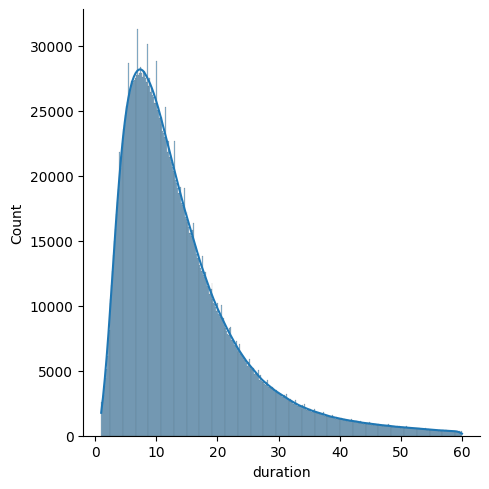

In [9]:
# Define the maximum duration to filter outliers
max_distance = 60

# Filter out the outliers
duration_with_no_outlier = df_train[df_train['duration'] <= max_distance]

# Plot the distribution of durations without outliers
sns.displot(duration_with_no_outlier['duration'], kde=True)

# Show the plot
plt.show()

In [10]:
categorical = ['PULocationID', 'DOLocationID']
target = 'duration'

# Ensure the categorical columns are treated as strings
df_train[categorical] = df_train[categorical].astype(str)
df_val[categorical] = df_val[categorical].astype(str)

# Convert the DataFrame to a list of dictionaries
train_dicts = df_train[categorical].to_dict(orient='records')
val_dicts = df_val[categorical].to_dict(orient='records')

# Initialize the DictVectorizer
dv = DictVectorizer()

# Fit and transform the training data
X_train = dv.fit_transform(train_dicts)

# Print the number of encoded features
print(f"The number of matrix-encoded features is: {X_train.shape[1]}")

# Transform the validation data
X_val = dv.transform(val_dicts)

# Extract the target values
y_train = df_train[target].values
y_val = df_val[target].values

# Train a linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the validation set
y_pred = model.predict(X_val)




The number of matrix-encoded features is: 515


#### Training the model and model performance Evaluation on training and validation set

 Base Model : Linear Regression

In [11]:
with mlflow.start_run():
    mlflow.set_tag('LinearRegression', model)
    mlflow.set_tag('developer', "Tiamz")
   
    mlflow.log_param('train-data-path', 'experiment_tracking/data/yellow_tripdata_2023-01.parquet')
    mlflow.log_param('validation-data-path', 'experiment_tracking/data/yellow_tripdata_2023-02.parquet')
    
    lr = LinearRegression()
    lr.fit(X_train, y_train)

    y_val_pred = lr.predict(X_val)

    y_pred = lr.predict(X_train)

    # Calculate the Root Mean Squared Error (RMSE)
    val_rmse = mean_squared_error(y_val, y_val_pred, squared=False)
    mlflow.log_metric('val_rmse', val_rmse)
    print(f"base model Root Mean Squared Error on validation set: {val_rmse}")
    
    train_rmse = mean_squared_error(y_train, y_pred, squared=False)
    mlflow.log_metric('train_rmse', train_rmse)
    print(f"base model Root Mean Squared Error on training set: {train_rmse}")






base model Root Mean Squared Error on validation set: 7.811817745843695
base model Root Mean Squared Error on training set: 7.649261934850555


/home/t.sukanmi/anaconda3/envs/exp_tracking/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/t.sukanmi/anaconda3/envs/exp_tracking/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


### Displaying the performance of the model

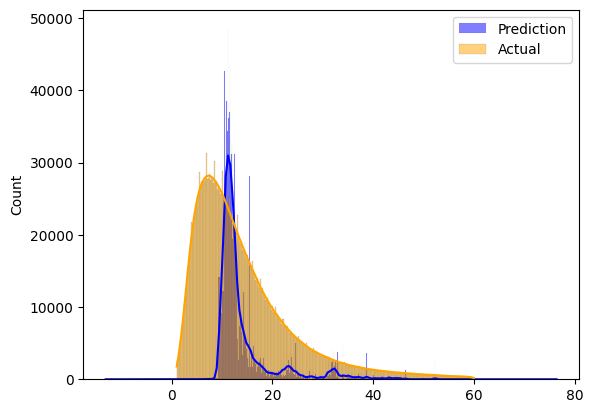

In [12]:
# Plot the distribution of predicted values
sns.histplot(y_val_pred, kde=True, label='Prediction', color='blue')

# Plot the distribution of actual values
sns.histplot(y_train, kde=True, label='Actual', color='orange')

# Add legend
plt.legend()

plt.show()



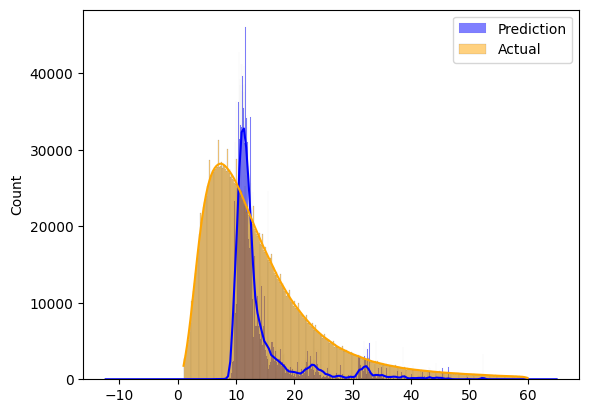

In [13]:
# Plot the distribution of predicted values
sns.histplot(y_pred, kde=True, label='Prediction', color='blue')

# Plot the distribution of actual values
sns.histplot(y_train, kde=True, label='Actual', color='orange')

# Add legend
plt.legend()

# Show the plot

plt.show()

In [14]:
len(df_train), len(df_val)

(3009173, 2855951)

In [15]:
with mlflow.start_run():
    mlflow.set_tag('developer', "Tiamz")
    mlflow.set_tag('model','Ridge')
    mlflow.log_param('train-data-path', 'experiment_tracking/data/yellow_tripdata_2023-01.parquet')
    mlflow.log_param('validation-data-path', 'experiment_tracking/data/yellow_tripdata_2023-02.parquet')

    alpha = 0.001
    mlflow.log_param('alpha', alpha)
    ridge = Ridge(alpha)

    ridge.fit(X_train, y_train)

    ridge_pred = ridge.predict(X_val)

    ridge_rmse = mean_squared_error(y_val, ridge_pred, squared=False)
    mlflow.log_metric('ridge_RMSE', ridge_rmse)
    
    print(f"ridge model Root Mean Squared Error on training set: {ridge_rmse}")

ridge model Root Mean Squared Error on training set: 7.811709415337387


/home/t.sukanmi/anaconda3/envs/exp_tracking/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [16]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [17]:
with mlflow.start_run():

    mlflow.set_tag('developer', "Tiamz")
    mlflow.set_tag('model', 'Lasso')
    mlflow.log_param('train-data-path', 'experiment_tracking/data/yellow_tripdata_2023-01.parquet')
    mlflow.log_param('validation-data-path', 'experiment_tracking/data/yellow_tripdata_2023-02.parquet')

    alpha = 0.01
    mlflow.log_param('alpha', alpha)
    las = Lasso(alpha)
    las.fit(X_train, y_train)

    las_pred = las.predict(X_val)

    las_rmse = mean_squared_error(y_val, las_pred, squared=False)
    mlflow.log_metric('RMSE', las_rmse)
    print(f"Lasso model Root Mean Squared Error on training set: {las_rmse}")

Lasso model Root Mean Squared Error on training set: 8.138118733385994


/home/t.sukanmi/anaconda3/envs/exp_tracking/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [18]:
import xgboost as xgb
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope


In [19]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

In [20]:
def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, 'validation')],
            early_stopping_rounds=50
        )
        y_pred = booster.predict(valid)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        mlflow.log_metric("rmse", rmse)

    return {'loss': rmse, 'status': STATUS_OK}

In [21]:
# search_space = {
#     'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
#     'learning_rate': hp.loguniform('learning_rate', -3, 0),
#     'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
#     'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
#     'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
#     'objective': 'reg:linear',
#     'seed': 42
# }

# best_result = fmin(
#     fn=objective,
#     space=search_space,
#     algo=tpe.suggest,
#     max_evals=50,
#     trials=Trials()
# )

In [22]:
with mlflow.start_run():
    
    train = xgb.DMatrix(X_train, label=y_train)
    valid = xgb.DMatrix(X_val, label=y_val)

    best_params = {
        'learning_rate': 0.09585355369315604,
        'max_depth': 30,
        'min_child_weight': 1.060597050922164,
        'objective': 'reg:linear',
        'reg_alpha': 0.018060244040060163,
        'reg_lambda': 0.011658731377413597,
        'seed': 42
    }

    mlflow.log_params(best_params)

    booster = xgb.train(
        params=best_params,
        dtrain=train,
        num_boost_round=1000,
        evals=[(valid, 'validation')],
        early_stopping_rounds=50
    )

    y_pred = booster.predict(valid)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric("rmse", rmse)

    with open("models/preprocessor.b", "wb") as f_out:
        pickle.dump(dv, f_out)
    mlflow.log_artifact("models/preprocessor.b", artifact_path="preprocessor")

    mlflow.xgboost.log_model(booster, artifact_path="models_mlflow")

/home/t.sukanmi/anaconda3/envs/exp_tracking/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:32:52] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[0]	validation-rmse:9.66700
[1]	validation-rmse:9.32544
[2]	validation-rmse:9.02772
[3]	validation-rmse:8.77833
[4]	validation-rmse:8.52259
[5]	validation-rmse:8.33312
[6]	validation-rmse:8.17951
[7]	validation-rmse:8.00152
[8]	validation-rmse:7.89076
[9]	validation-rmse:7.79476
[10]	validation-rmse:7.71204
[11]	validation-rmse:7.64024
[12]	validation-rmse:7.57481
[13]	validation-rmse:7.52044
[14]	validation-rmse:7.46677
[15]	validation-rmse:7.35188
[16]	validation-rmse:7.31632
[17]	validation-rmse:7.28409
[18]	validation-rmse:7.25377
[19]	validation-rmse:7.15253
[20]	validation-rmse:7.12958
[21]	validation-rmse:7.10918
[22]	validation-rmse:7.02467
[23]	validation-rmse:7.00793
[24]	validation-rmse:6.98921
[25]	validation-rmse:6.97384
[26]	validation-rmse:6.95163
[27]	validation-rmse:6.93886
[28]	validation-rmse:6.84799
[29]	validation-rmse:6.83748
[30]	validation-rmse:6.76422
[31]	validation-rmse:6.75510
[32]	validation-rmse:6.74551
[33]	validation-rmse:6.73503
[34]	validation-rmse:6.6

/home/t.sukanmi/anaconda3/envs/exp_tracking/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/t.sukanmi/anaconda3/envs/exp_tracking/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:55:59] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


In [25]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import LinearSVR
import mlflow.sklearn

mlflow.sklearn.autolog()

for model_class in (RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, LinearSVR):
    with mlflow.start_run():
        mlflow.log_param("train-data-path", "./data/green_tripdata_2021-01.csv")
        mlflow.log_param("valid-data-path", "./data/green_tripdata_2021-02.csv")
        mlflow.log_artifact("models/preprocessor.b", artifact_path="preprocessor")

        mlmodel = model_class()
        mlmodel.fit(X_train, y_train)

        y_pred = mlmodel.predict(X_val)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        mlflow.log_metric("rmse", rmse)

        mlflow.sklearn.log_model(mlmodel, artifact_path="models_mlflow")


2024/05/23 15:08:59 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of sklearn. If you encounter errors during autologging, try upgrading / downgrading sklearn to a supported version, or try upgrading MLflow.
2024/05/23 15:08:59 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/t.sukanmi/anaconda3/envs/exp_tracking/lib/python3.9/site-packages/_distutils_hack/__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils."
2024/05/23 15:08:59 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/t.sukanmi/anaconda3/envs/exp_tracking/lib/py

AssertionError: /home/t.sukanmi/anaconda3/envs/exp_tracking/lib/python3.9/distutils/core.py